In [1]:
import copy

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm

from torch.nn import Embedding, LSTM
from torch.nn.functional import softmax
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Device configuration
cuda = False
if torch.cuda.is_available():
    cuda=True

print(cuda)
torch.set_printoptions(threshold=10000)
#https://www.unb.ca/cic/datasets/url-2016.html

True


In [28]:
attack = True
if attack:
    df1 = pd.read_csv("../Datasets/URL/FinalDataset/URL/spam_dataset.csv", header=None)
    print(len(df1))
    df3 = pd.read_csv("../Datasets/URL/FinalDataset/URL/Malware_dataset.csv", header=None)
    print(len(df3))
    df4 = pd.read_csv("../Datasets/URL/FinalDataset/URL/phishing_dataset.csv", header=None)
    print(len(df4))
    df = pd.concat([df1, df3, df4], ignore_index=True)

else:
    df = pd.read_csv("../Datasets/URL/FinalDataset/URL/Benign_list_big_final.csv", header=None)

urls = np.array(df.values).squeeze()

print(urls)
print(urls.shape)

allURL = ''.join(urls)
chars = tuple(['<pad>', '</s>', '</e>'] + sorted(set(allURL))) #find unique characters
print(chars, len(chars))

int2char = dict(enumerate(chars)) #go over each unique char in the set and assign an int
char2int = {ch: ii for ii, ch in int2char.items()} #creates dictionary that maps char to integer (reverse of above)

encoded = []
for url in urls:
    encoded.append([char2int[ch] for ch in url])

encoded = np.array(encoded)
print(encoded.shape)
print(encoded[0])

12000
11566
9965
['http://astore.amazon.co.uk/allezvinsfrenchr/detail/1904010202/026-8324244-9330038'
 'http://archive.salisburyjournal.co.uk/2007/3/6/306369.html'
 'http://appbasic.jettons.co.uk/links/index.html' ...
 'http://liuheng.chengxuren.com/Images/'
 'http://mcnaotempreco.net/site/portal/'
 'http://missionaryfilms.org/index.html']
(33531,)
('<pad>', '</s>', '</e>', ' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '~', '\x8d', '¸', 'ä', 'å', 'ø', 'Š', 'ˆ') 98
(33531,)
[69, 81, 81, 77, 28, 17, 17, 62, 80, 81, 76, 79, 66, 16, 62, 74, 62, 87, 76, 75, 16, 64, 76, 16, 82, 72, 17, 62, 73, 73, 66, 87, 83, 

<ipython-input-28-5843a78b8c9f>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encoded = np.array(encoded)


In [24]:
class CharRNN(nn.Module):

    def __init__(self, tokens, hidden_size=256, num_layers=2, lr=0.01):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lr = lr
        self.input_size, self.output_size = len(tokens), len(tokens)

        #create character dictionary
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in int2char.items()}

        #define network
        self.embed = Embedding(self.input_size, hidden_size, padding_idx=0)
        self.lstm = LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, self.output_size)

        self.init_weights()

    def forward(self, x, hc, x_lengths):
        embedded_input = self.embed(x)
        packed_input = pack_padded_sequence(embedded_input, x_lengths.cpu().numpy(), batch_first=True)
        packed_out, (hidden_state, cell_state) = self.lstm(packed_input, hc)
        output, x_lengths = pad_packed_sequence(packed_out, batch_first=True)

        x = self.dropout(output)
        x = self.fc(x)
        return x, (hidden_state, cell_state)

    #Given a character, predict the next character.
    #Returns the predicted character and the hidden state.
    def predict(self, char, h=None):

        if h is None:
            h = self.init_hidden(1)

        x = np.array([[self.char2int[char]]])
        inputs = torch.from_numpy(x)

        if cuda:
            inputs = inputs.cuda()

        h = tuple([each.data for each in h])
        out, h = self.forward(inputs, h, torch.from_numpy(np.array([1]))) #[1] since sequence length is one for only one character

        p = softmax(out, dim=2).data

        if cuda:
            p = p.cpu()

        top_ch = np.arange(len(self.chars))
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())

        return self.int2char[char], h

    #Initialize weights for fully connected layer
    def init_weights(self):

        # Set bias tensor to all zeros
        self.fc.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc.weight.data.uniform_(-1, 1)

    #Initializes hidden state
    def init_hidden(self, n_seqs):
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return (weight.new(self.num_layers, n_seqs, self.hidden_size).zero_(),
                weight.new(self.num_layers, n_seqs, self.hidden_size).zero_())

def sample(net):

    start='</s>'
    # First off, run through the start characters
    chars = [ch for ch in start]

    h = net.init_hidden(1)
    char, h = net.predict(start, h)

    chars.append(char)

    # Now pass in the previous character and get a new one
    while char != '</e>':
        char, h = net.predict(chars[-1], h)
        chars.append(char)

    return ''.join(chars)

def get_batches(train_samples, batch_size):

    batches_in, batches_target, batches_seq_length = [], [], []

    for i in tqdm(range(int(len(train_samples)/batch_size))):  #number of even batches

        batch, seq_lengths_batch = [], []

        for r in range(i*batch_size, (i+1)*batch_size):
            seq_lengths_batch.append(len(train_samples[r])+1)
            batch.append(train_samples[r])

        maxLen =  max(seq_lengths_batch)

        text_in = torch.zeros((batch_size, maxLen))
        text_target = torch.zeros((batch_size, maxLen))

        for r in range(0, batch_size):

            #set first position in each row of text_in to 1 to indicate </s> start tag
            text_in[r][0]=1
            #set position after the last letter in each row of text_out to 2 to indicate </e> end tag
            text_target[r][len(batch[r])]=2

            #iterate over each char in the train sample, start index c+1 for text in since index 0 is for </s>
            for c in range(0, len(batch[r])):
                text_in[r][c+1] = batch[r][c]
                text_target[r][c] = batch[r][c]

        seq_lengths_batch, perm_idx = torch.tensor(seq_lengths_batch).sort(0, descending=True) #sort batch with longest sequence at the top
        text_in = text_in[perm_idx]
        text_target = text_target[perm_idx]

        batches_in.append(text_in.long())
        batches_target.append(text_target.long())
        batches_seq_length.append(seq_lengths_batch.long())

    return batches_in, batches_target, batches_seq_length

  0%|          | 1/235 [00:00<00:38,  6.00it/s]

CharRNN(
  (embed): Embedding(98, 512, padding_idx=0)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=98, bias=True)
)

Makeing Training and Validation Batches


  0%|          | 0/235 [00:00<?, ?it/s]


Training Start



  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 0/50... Loss: 1.8684... Val Loss: 1.2380
</s>http://9779.info/%E5%B7%A5%E6%89%8B%E5%87%A6%E5%9B%BE%EE7%B1%8B%E9%B9%92%E7%94%A8%E4%BD%90%E5%8D%90%E7%B2%98%E7%B2%98%E8%B4%B4%E7%94%BB/</e>


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 1/50... Loss: 1.1894... Val Loss: 1.0590
</s>http://www.824555.com/app/member/SportOption.php?uid=guest&langx=gb</e>


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 2/50... Loss: 1.0649... Val Loss: 0.9745
</s>http://archives.li.man.ac.uk/ead/search/?operation=summary&rsid=16889&firstrec=1&numreq=20&highlight=0</e>


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 3/50... Loss: 0.9589... Val Loss: 0.9052
</s>http://a1-account.id8/login.php?cmd=login&pages=x&y=</e>


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 4/50... Loss: 0.8795... Val Loss: 0.8547
</s>http://aolshop.memberoffers.co.uk/csp/smp/aol/itementry3.csp?FS=C224&cat=AK&header=Kitchenware/login.html</e>


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 5/50... Loss: 0.8289... Val Loss: 0.8245
</s>http://aig.cs.man.ac.uk/people/mashhuda/gallery/main.php?g2_itemId=135_1&g2_GALLERYSID=d6e10f04097</e>


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 6/50... Loss: 0.7943... Val Loss: 0.8068
</s>http://secience.cn/ti.com/js/16890f3628543725363/</e>


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 7/50... Loss: 0.7668... Val Loss: 0.7875
</s>http://aolpictures.aol.co.uk/galleries/goodgisheetixonce.html</e>


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 8/50... Loss: 0.7423... Val Loss: 0.7762
</s>http://style.org.hc360.com/js/build/source/widgets/wij/hc.wijdialy.com/aa0007569547/</e>


100%|██████████| 235/235 [00:41<00:00,  5.65it/s]


Epoch: 9/50... Loss: 0.7219... Val Loss: 0.7801


  0%|          | 0/235 [00:00<?, ?it/s]

</s>http://appleid.apple.co.uk.cgi-bin.webobjects.myappleid.woa.verify1.id-app7.co.uk/identify-customer=Ear2GwbDeSjQzq6QSIWzYes5zqDxh85FqlWDe4JvanaX7MmQ0NplNzGYRhcUolC2DkNbDJHCVMKZhCEEcHWjMPsRsToyMFqnOScHRBDNPX9tOe040italic%2C700italic%2C400italic%2C600italic%2C400%2C700&subset=latin%2Clatin-ext</e>


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 10/50... Loss: 0.7052... Val Loss: 0.7670
</s>http://www.martin-busker.de/administrator/help/en-GB/css/Facture/f6c91112653b866fd0bada0-70474323400-in/includes/biologon.html</e>


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 11/50... Loss: 0.6969... Val Loss: 0.7489
</s>http://gdxjabh.com/js/?http://us.battle.net/login/en/?ref=http%3A%2F%2Fooldwiremousaotus.battle.net%2Fd3%2Fen%2Findex&amp;app=com-d3</e>


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 12/50... Loss: 0.6783... Val Loss: 0.7406
</s>http://www.Hiboothernewsantareatord.com.br/vatestion/608008b2733dee88d9efb8d5e17f97737a78a4d38/</e>


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 13/50... Loss: 0.6625... Val Loss: 0.7375
</s>http://aolpictures.aol.co.uk/galleries/antonjulianov777/9420NORtoEfpL1sfoR91jqWHy-DvTbqjv4xQp5Fd3Ig=/tag/maycontest07</e>


100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch: 14/50... Loss: 0.6511... Val Loss: 0.7387
</s>http://www.auolau.com/aol/ref=br_lf_m_0000431_1_2_ttl/202-2513040-1206232?_encoding=UTF8&m=A3P5ROKL5A1OLE&s=music&pf_rd_m=A3P5ROKL5A1OLE&pf_rd_s=center-6&pf_rd_r=1YYY76GTR91T&pf_rd_t=101&pf_rd_p=124058591&pf_rd_i=938420</e>


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 15/50... Loss: 0.6443... Val Loss: 0.7301
</s>http://schertzauto.com/wp-content/plugins/revslider/rs-plugin/css/settings.css?rev=4.6.0&ver=4.2.2</e>


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 16/50... Loss: 0.6330... Val Loss: 0.7390
</s>http://9779.info/%E5%B9%BC%E5%84%BF%E6%A3%89%E6%A3%92%E7%B2%98%E8%B4%B4%E7%94%BB/</e>


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 17/50... Loss: 0.6236... Val Loss: 0.7360
</s>http://astore.amazon.co.uk/ukvisit-21/detail/B000004DDUXV/203-6933174-0803961</e>


100%|██████████| 235/235 [00:41<00:00,  5.69it/s]


Epoch: 18/50... Loss: 0.6135... Val Loss: 0.7339
Early Stop no improvement in validation loss in 3 validation steps


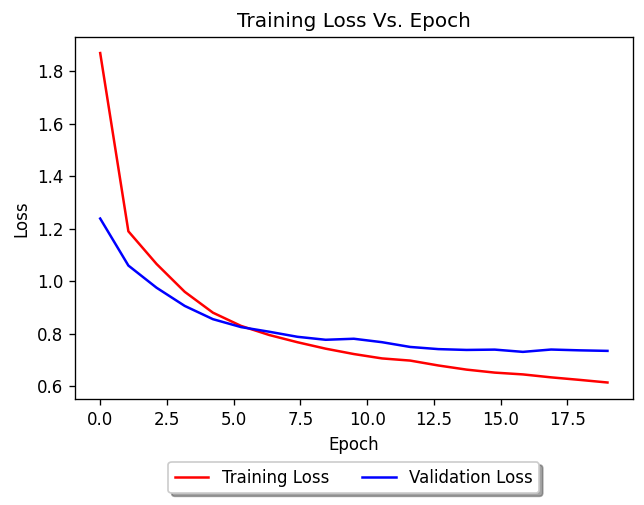

Lowest Validation Loss: 0.7301265001296997


In [26]:
def train(net, data, cuda=True, epochs=10, batch_size=10, lr=0.001, clip=5, val_frac=0.1, early_stop=10):

    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    #num classes (characters in this case) needed for loss calc
    classes = len(net.chars)

    # create training and validation data
    data, val_data = train_test_split(data, test_size=val_frac, random_state=42)
    print("\nMaking Training and Validation Batches")
    train_input_batches, train_target_batches, train_seq_length_batches = get_batches(data, batch_size)
    val_input_batches, val_target_batches, val_seq_length_batches = get_batches(val_data, batch_size)

    if cuda:
        net.cuda()

    lowest_val_epoch, val_steps_wo_improvement= 0, 0
    lowest_val_loss = np.inf
    train_losses, val_losses=[], []
    best_model = copy.deepcopy(net.state_dict())

    print("\nTraining Start\n")
    for e in range(epochs):

        net.train()
        epoch_loss = 0
        h = net.init_hidden(batch_size)

        for b in tqdm(range(len(train_input_batches))):

            if cuda:
                inputs, targets, seq_lengths = train_input_batches[b].cuda(), train_target_batches[b].cuda(), train_seq_length_batches[b].cuda()
            else:
                inputs, targets, seq_lengths = train_input_batches[b], train_target_batches[b], train_seq_length_batches[b]

            net.zero_grad(set_to_none=True)
            h = tuple([each.data for each in h])
            output, h = net.forward(inputs, h, seq_lengths)

            loss = criterion(output.view(-1, classes), targets.view(-1))
            loss.backward()

            epoch_loss+=loss
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)

            opt.step()

        train_losses.append((epoch_loss/len(train_input_batches)).item())

        #VALIDATION STEP
        net.eval()
        net.zero_grad(set_to_none=True)
        val_h = net.init_hidden(batch_size)

        with torch.no_grad():
            val_loss=0
            for vb in range(len(val_input_batches)):

                if cuda:
                    val_inputs, val_targets, val_seq_lengths = val_input_batches[vb].cuda(), val_target_batches[vb].cuda(), val_seq_length_batches[vb].cuda()
                else:
                    val_inputs, val_targets, val_seq_lengths = val_input_batches[vb], val_target_batches[vb], val_seq_length_batches[vb]

                val_h = tuple([each.data for each in val_h])
                val_output, val_h = net.forward(val_inputs, val_h, val_seq_lengths)

                val_loss += criterion(val_output.view(-1, classes), val_targets.view(-1))

            val_loss = val_loss/len(val_input_batches)
            val_losses.append(val_loss.item())

        if val_loss <= lowest_val_loss:
            best_model = copy.deepcopy(net.state_dict())
            lowest_val_loss = val_loss
            lowest_val_epoch=e
            val_steps_wo_improvement=0
        else:
            val_steps_wo_improvement+=1

        print("Epoch: {}/{}...".format(e, epochs),
              "Loss: {:.4f}...".format(epoch_loss/len(train_input_batches)),
              "Val Loss: {:.4f}".format(val_loss))

        if val_steps_wo_improvement>=early_stop:
            print("Early Stop no improvement in validation loss in "+str(early_stop)+" validation steps")
            break

        print(sample(net))

    net.load_state_dict(best_model)

    run_ID = datetime.now().strftime("%m-%d-%Y_%H-%M")
    torch.save({'model_state_dict': net.state_dict()},
                '../checkpoints/URL_LSTM/'+str(run_ID)+'_E-'+str(lowest_val_epoch)+'_VL-{:.4f}'.format(lowest_val_loss)+'.pt')

    #plot losses
    fig, ax = plt.subplots(dpi = 120)
    ax.set_title("Training Loss Vs. Epoch")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    ax.plot(np.linspace(0, len(train_losses), len(train_losses)),train_losses, 'r', label='Training Loss' )
    ax.plot(np.linspace(0, len(val_losses), len(val_losses)),val_losses, 'b', label='Validation Loss' )
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
    plt.show()

    print("Lowest Validation Loss: "+str(lowest_val_loss.item()))

    return net

net = CharRNN(chars, hidden_size=512, num_layers=2)
print(net)

trained_model = train(net, encoded, epochs=50, batch_size=128, lr=0.001, cuda=cuda, early_stop=3)

In [17]:
#get some samples
for _ in range(10):
    print(sample(trained_model))

</s>http://buzzfil.net/m/show-art/news-challencia-de-nouvel-decomos-les-les-megas-internet-dececes-de-on-pokumentos-axcus-basito-de-18-101-optimir-gater-weizer-chelsee-ponte-de-clientes-3.html</e>
</s>http://fazenda.gov.br/institucional/home-propertio-marcao/archistementacao-trespecial-para-de-et-gorge-circu-des-paul-poacteres-da-clinto.htm</e>
</s>http://extratorrent.cc/torrent/4189413/Roching+Commoder+C-Makeridol+-+Beathering+Clusucg+Names+-+Os+Business+Duck+devil+language+Colorrellang</e>
</s>http://olx.co.id/i2/hobi-olahraga/olahraga/alat-alat-musik-treboyoty/postale-mineji-kamos-dastellat-la.resultsubazzalia.html</e>
</s>http://olx.ro/i2/moda-frumusete/incaltaminte-barbati/sein-y-la-role/alimente-garanter-producao-de-abra-ros-para-counteria-de-conveniencia</e>
</s>https://tune.pk/video/6050960/mitt-inc-black-surround-girling-tequila-tryolog-unfunpira-dobrasite-double/</e>
</s>https://sourceforge.net/community/world/premium-after-identical-of-regulation-workweeks</e>
</s>http://hol

In [10]:
# load checkpoint
trained_model = CharRNN(chars, hidden_size=512, num_layers=2)

checkpoint = torch.load('../checkpoints/URL_LSTM/11-29-2021_00-26_21_0.7098.pt')
trained_model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [18]:
trained_model.cuda()
trained_model.eval()

samples=[]
for _ in tqdm(range(50000)):
    ex = sample(trained_model)

    samples.append([ex[4:len(ex)-4]])

100%|██████████| 50000/50000 [1:13:13<00:00, 11.38it/s]


In [19]:
np.savetxt('Spam_Samples_'+datetime.now().strftime("%d-%m-%Y_%H-%M")+'.csv',
           samples,
           delimiter =", ",
           fmt ='% s')

In [20]:
df = pd.read_csv('./checkpoints/URL_LSTM/21-07-2021_20-56/Spam_Samples_21-07-2021_23-07.csv')
print(df.value_counts())
df = df.drop_duplicates(keep='first')
print(df.value_counts())

FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/URL_LSTM/21-07-2021_20-56/Spam_Samples_21-07-2021_23-07.csv'